In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [4]:
file_path = os.path.dirname(os.getcwd()) + "/raw_data/"

effort_data = pd.read_excel(file_path + "FAOEffortBOB.xlsx", sheet_name="MappedFAO")
capture_data = pd.read_csv(file_path + "Capture_quantity.csv")
country_codes = pd.read_csv(file_path + "Country_codes.csv")
isscaap_codes = pd.read_csv(file_path + "ASFIS_sp_2024.csv")
isscaap_codes = isscaap_codes.rename(
    columns={"Alpha3_Code": "SPECIES.ALPHA_3_CODE", "ISSCAAP_GROUP ": "ISSCAAP_GROUP"}
)

un_to_iso3 = dict(zip(country_codes["UN"], country_codes["ISO3"]))
capture_data["COUNTRY.UN_CODE"] = capture_data["COUNTRY.UN_CODE"].map(un_to_iso3)
capture_data.rename(columns={"COUNTRY.UN_CODE": "ISO3", "PERIOD": "Year"}, inplace=True)

In [27]:
capture_data2 = pd.read_csv(file_path + "global_capture_production.csv")
stocks_data = pd.read_csv(file_path + "2021_stocks.csv").dropna()
stocks_data = stocks_data[["Area", "ASFIS Name", "Location", "Status"]].drop_duplicates()

In [20]:
print(len(capture_data2))
print(len(capture_data2[["Country (Name)", "ASFIS species (Name)", "FAO major fishing area (Name)"]].drop_duplicates()))

28498
28498


In [29]:
print(len(stocks_data))
print(len(stocks_data[["Area", "ASFIS Name", "Location"]].drop_duplicates()))
stock_data_dup = stocks_data[stocks_data[["Area", "ASFIS Name", "Location"]].duplicated()]
print(stock_data_dup)

1864
1812
      Area                ASFIS Name  \
231     27               Salmo salar   
291     27       Nephrops norvegicus   
292     27       Nephrops norvegicus   
380     31           Panulirus argus   
381     31           Panulirus argus   
437     34           Cynoglossus spp   
442     34    Brachydeuterus auritus   
457     34    Galeoides decadactylus   
480     34        Pseudotolithus spp   
508     34              Aristeus spp   
509     34              Aristeus spp   
566     41          Cynoscion acoupa   
572     41        Macrodon ancylodon   
599     41       Prionotus punctatus   
611     41      Xiphopenaeus kroyeri   
737     51             Istiophoridae   
813     51                Carangidae   
817     51                Carangidae   
851     51           Epinephelus spp   
1067    51          Scomberoides spp   
1128    51             Panulirus spp   
1151    51               Penaeus spp   
1175    51               Cephalopoda   
1511    61           Clupea pa

In [54]:
effort_data = (
    effort_data.groupby(["Year", "ISO3"])[
        [
            "EffortCellReportedNom",
            "EffortCellReportedEff",
            "EffortCellIUUNom",
            "EffortCellIUUEff",
        ]
    ]
    .sum()
    .reset_index()
)

CE_data = pd.merge(
    capture_data,
    effort_data,
    on=["ISO3", "Year"],
    how="inner",
)

CE_data = CE_data.dropna()
CE_data["CPUE"] = CE_data["VALUE"] / CE_data["EffortCellReportedEff"]

CE_data = pd.merge(CE_data, isscaap_codes[["ISSCAAP_Group ", "SPECIES.ALPHA_3_CODE", "Scientific_Name"]], how="inner")

print(CE_data)


       ISO3 SPECIES.ALPHA_3_CODE  AREA.CODE MEASURE  Year  VALUE STATUS  \
0       ALB                  FCP          5   Q_tlw  2015  480.0      A   
1       ALB                  FCP          5   Q_tlw  2014  434.0      A   
2       ALB                  FCP          5   Q_tlw  2013  418.0      A   
3       ALB                  FCP          5   Q_tlw  2012  398.0      A   
4       ALB                  FCP          5   Q_tlw  2011  450.0      A   
...     ...                  ...        ...     ...   ...    ...    ...   
811074  VNM                  CDS          4  Q_no_1  1974    0.0      A   
811075  VNM                  CDS          4  Q_no_1  1973    0.0      A   
811076  VNM                  CDS          4  Q_no_1  1972    0.0      A   
811077  VNM                  CDS          4  Q_no_1  1971    0.0      A   
811078  VNM                  CDS          4  Q_no_1  1970    0.0      A   

        EffortCellReportedNom  EffortCellReportedEff  EffortCellIUUNom  \
0                1.796628

/var/folders/3h/wffpfgs16x35fp5xl_dt66mm0000gn/T/ipykernel_79404/3222931897.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example = CE_21[CE_21["Scientific_Name"] == "Clupea harengus"][CE_21["ISO3"] == 'USA']


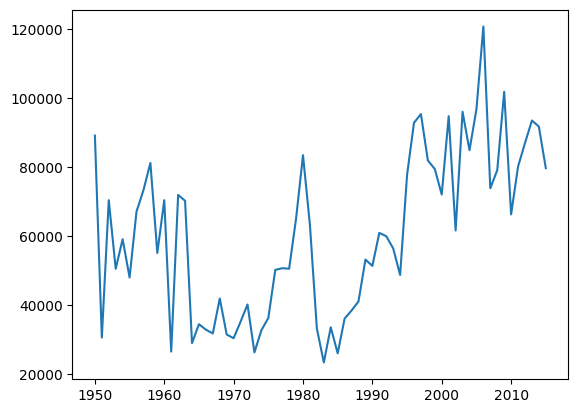

In [50]:
CE_21 = CE_data[CE_data["AREA.CODE"] == 21]

example = CE_21[CE_21["Scientific_Name"] == "Clupea harengus"][CE_21["ISO3"] == 'USA']

plt.plot(example["Year"], example["VALUE"])
plt.show()

In [55]:
CE_grouped = [
    group.reset_index().dropna()
    for _, group in CE_data.groupby(["ISO3", "SPECIES.ALPHA_3_CODE"])
]

In [67]:
CE_reduced = [d.dropna() for d in CE_grouped if 2015 in list(d.dropna()["Year"])]

print(len(CE_reduced))

13863


In [156]:
global_capture_production = pd.read_csv(file_path + "global_capture_production.csv")

asfis = pd.read_csv(file_path + "ASFIS_sp_2024.csv")[["Scientific_Name", "English_name"]].set_index("English_name")["Scientific_Name"].to_dict()

{'Siamese algae-eater': 'Gyrinocheilus aymonieri', 'River carpsucker': 'Carpiodes carpio', 'Longnose sucker': 'Catostomus catostomus', 'White sucker': 'Catostomus commersonii', 'Flannelmouth sucker': 'Catostomus latipinnis', 'Largescale sucker': 'Catostomus macrocheilus', 'Tahoe sucker': 'Catostomus tahoensis', 'Cui-ui': 'Chasmistes cujus', 'Blue sucker': 'Cycleptus elongatus', 'Lost River sucker': 'Deltistes luxatus', 'Lake chubsucker': 'Erimyzon sucetta', 'Northern hog sucker': 'Hypentelium nigricans', 'Bigmouth buffalo': 'Ictiobus cyprinellus', 'Buffalofishes NEI': 'Ictiobus spp', 'Spotted sucker': 'Minytrema melanops', 'Gray redhorse': 'Moxostoma congestum', 'Golden redhorse': 'Moxostoma erythrurum', 'Harelip sucker': 'Moxostoma lacerum', 'Shorthead redhorse': 'Moxostoma macrolepidotum', 'Chinese sucker': 'Myxocyprinus asiaticus', 'Razorback sucker': 'Xyrauchen texanus', 'Suckers NEI': 'Catostomidae', 'Bengal loach': 'Botia dario', nan: 'Alcidae', 'Clown loach': 'Chromobotia macrac

In [174]:
num_pairs = capture_data[["ISO3", "SPECIES.ALPHA_3_CODE"]].dropna().drop_duplicates()
num_ts = capture_data[["ISO3", "SPECIES.ALPHA_3_CODE", "VALUE"]].dropna()[capture_data["Year"] == 2021]

print(num_pairs)
print(num_ts)

        ISO3 SPECIES.ALPHA_3_CODE
0        AFG                  FRF
73       ALB                  FCP
122      ALB                  ALR
150      ALB                  FCC
196      ALB                  FRX
...      ...                  ...
1049551  URY                  SEL
1049620  VEN                  CAI
1049655  VNM                  CDS
1049708  ZMB                  CRI
1049744  ZWE                  CRI

[19764 rows x 2 columns]
        ISO3 SPECIES.ALPHA_3_CODE     VALUE
1        AFG                  FRF    1800.0
74       ALB                  FCP     654.0
123      ALB                  ALR     133.0
151      ALB                  FCC     930.0
197      ALB                  FRX     614.0
...      ...                  ...       ...
1049444  USA                  AGM  411921.0
1049620  VEN                  CAI    3788.0
1049656  VNM                  CDS   16292.0
1049709  ZMB                  CRI   13115.0
1049745  ZWE                  CRI   87460.0

[19653 rows x 3 columns]
18677


/var/folders/3h/wffpfgs16x35fp5xl_dt66mm0000gn/T/ipykernel_79404/1411351802.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  num_ts = capture_data[["ISO3", "SPECIES.ALPHA_3_CODE", "VALUE"]].dropna()[capture_data["Year"] == 2021]


In [173]:
capture_grouped = capture_data.groupby(["ISO3", "SPECIES.ALPHA_3_CODE"])

capture_ts = [group for _, group in capture_grouped if 2021 in list(group["Year"])]

15212


In [182]:
years = range(1950, 2022)
capture_ts_filled = []
for group in capture_ts:
    iso, species, area = group[["ISO3", "SPECIES.ALPHA_3_CODE", "AREA.CODE"]].iloc[0]

    group_filled = pd.DataFrame(
        [(iso, species, area, year) for year in years],
        columns=["ISO3", "SPECIES.ALPHA_3_CODE", "AREA.CODE", "Year"],
    )

    group_filled = group_filled.merge(
        group, on=["ISO3", "SPECIES.ALPHA_3_CODE", "AREA.CODE", "Year"], how="left"
    )

    group_filled["VALUE"] = group_filled["VALUE"].fillna(0)

    group_filled = group_filled[["ISO3", "SPECIES.ALPHA_3_CODE", "AREA.CODE", "Year", "VALUE"]]

    capture_ts_filled.append(group_filled)

In [188]:
with open("capture_ts.pkl", "wb") as file:
    pickle.dump(capture_ts_filled, file)

In [193]:
countries = global_capture_production["Country (Name)"].drop_duplicates()
countries.drop(countries.tail(3).index, inplace=True)

with open("countries_list.pkl", "wb") as file:
    pickle.dump(countries, file)

In [74]:
area_to_country = (
    global_capture_production[["Country (Name)", "FAO major fishing area (Name)"]]
    .groupby("FAO major fishing area (Name)")["Country (Name)"]
    .apply(lambda x: list(set(x)))
    .reset_index()
    .rename(
        columns={"Country (Name)": "Countries", "FAO major fishing area (Name)": "Area"}
    )
)

In [89]:
area_codes = {
    "Atlantic, Northwest": 21,
    "Atlantic, Northeast": 27,
    "Atlantic, Western Central": 31,
    "Atlantic, Eastern Central": 34,
    "Mediterranean and Black Sea": 37,
    "Atlantic, Southwest": 41,
    "Atlantic, Southeast": 47,
    "Indian Ocean, Western": 51,
    "Indian Ocean, Eastern": 57,
    "Pacific, Northwest": 61,
    "Pacific, Northeast": 67,
    "Pacific, Western Central": 71,
    "Pacific, Eastern Central": 77,
    "Pacific, Southwest": 81,
    "Pacific, Southeast": 87,
}

filtered_areas = area_to_country[area_to_country["Area"].isin(area_codes.keys())]

filtered_areas["Area"] = filtered_areas["Area"].map(area_codes)

filtered_areas = filtered_areas.sort_values("Area").reset_index(drop=True)

print(filtered_areas)

    Area                                          Countries
0     21  [Republic of Korea, Latvia, Lithuania, Greenla...
1     27  [Republic of Korea, Morocco, Latvia, Lithuania...
2     31  [Republic of Korea, Haiti, Jamaica, Lithuania,...
3     34  [Republic of Korea, Argentina, Morocco, Latvia...
4     37  [Republic of Korea, Morocco, Türkiye, Japan, G...
5     41  [Republic of Korea, Argentina, Latvia, Lithuan...
6     47  [Republic of Korea, Latvia, Lithuania, Japan, ...
7     51  [Republic of Korea, Sri Lanka, Djibouti, Lithu...
8     57  [Bangladesh, Republic of Korea, Sri Lanka, Jap...
9     61  [China, Macao SAR, Russian Federation, Republi...
10    67  [Bulgaria, Russian Federation, Republic of Kor...
11    71  [Republic of Korea, Guam, Viet Nam, Japan, Wal...
12    77  [Republic of Korea, Lithuania, Japan, Nicaragu...
13    81  [Republic of Korea, Latvia, Lithuania, Japan, ...
14    87  [Republic of Korea, Argentina, Latvia, Lithuan...


/var/folders/3h/wffpfgs16x35fp5xl_dt66mm0000gn/T/ipykernel_79404/1766291578.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_areas["Area"] = filtered_areas["Area"].map(area_codes)


In [91]:
import pickle

with open("area_to_country.pkl", "wb") as file:
    pickle.dump(filtered_areas, file)

In [146]:
global_capture_production = global_capture_production.rename(
    columns={
        "Country (Name)": "Country",
        "ASFIS species (Name)": "ASFIS species",
        "FAO major fishing area (Name)": "Area",
    }
)

global_capture_production["Area"] = global_capture_production["Area"].map(area_codes)

print(global_capture_production)

                                                 Country  \
0                                            Afghanistan   
1                                                Albania   
2                                                Albania   
3                                                Albania   
4                                                Albania   
...                                                  ...   
28493                                           Zimbabwe   
28494                                           Zimbabwe   
28495                      Totals - Tonnes - live weight   
28496                                    Totals - Number   
28497  FAO. 2024. FishStat: Global capture production...   

                      ASFIS species  Area           Unit (Name)         Unit  \
0             Freshwater fishes nei   NaN  Tonnes - live weight  TLW, Number   
1      Angelsharks, sand devils nei   NaN  Tonnes - live weight  TLW, Number   
2             Atlantic bluefin tuna   N

In [116]:
data_2021 = []

areas = [21, 27, 31, 34, 41, 47, 51, 57, 61, 67, 71, 77]

for a in areas:
    skip = 3 if a == 47 else 0
    data_2021.append(pd.read_excel(file_path + "area" + str(a) + ".xlsx", skiprows=skip))

df_2021 = pd.DataFrame(columns=["ISSCAAP", "ASFIS", "Location", "Status"])

In [125]:
area21 = pd.read_excel(file_path + "area21.xlsx")
print(area21.columns)

Index(['Code', 'ISSCAAP Group (Name)', 'Stock - ASFIS name',
       'ASFIS Scientific Name', 'Possible proxy', 'Location / season',
       'Location', 'Fleet (industrial/SSF/both)', 'Tier', 'Year',
       'In FishStat', 'Status', 'check ASFIS',
       'Uncertainty (H,L,M) \n see below', 'In previous', 'Biomass (B/Bmsy)',
       '1950 Landings', 'Landings (tonnes) 2021', 'Landings in Area 1950',
       '2021 Landings in Area', 'MSY level estimates (tonnes)', 'F level',
       'Proxy landings in 1950', 'Proxy landings in 2021',
       ' in FishStatJ Area historic > 0.0t',
       'indicated in Map https://www.fao.org/fishery/en/area/21/en ',
       'Changed ASFIS name', 'Not in FishStatJ'],
      dtype='object')


In [139]:
for area, a in zip(data_2021, areas):
    loc = "Country"
    sn = "ASFIS Scientific Name"
    st = "Assessment"
    cd = "Code"
    if loc not in area.columns:
        if "Location" in area.columns:
            loc = "Location"
        else:
            loc = "Location (Country? geographic region?)"
    if sn not in area.columns:
        if "Scientific name" in area.columns:
            sn = "Scientific name"
        elif "Scientific Name" in area.columns:
            sn = "Scientific Name"
        elif "Scientific name in Data" in area.columns:
            sn = "Scientific name in Data"
        elif "Scientific name ASFIS" in area.columns:
            sn = "Scientific name ASFIS"
        elif "Species" in area.columns:
            sn = "Species"
        else:
            sn = "Species/ Group"
    if st not in area.columns:
        if "Status" in area.columns:
            st = "Status"
        elif "M" in area.columns:
            st = "M"
        else:
            st = "Status (3 levels)"
    if cd not in area.columns:
        if "ISSCAAP Code" in area.columns:
            cd = "ISSCAAP Code"
        elif "Sp.group" in area.columns:
            cd = "Sp.group"
        else:
            cd = "ISSCAAP Group Code"
    temp = area[[cd, sn, loc, st]]
    temp = temp.rename(columns={cd: "ISSCAAP", sn: "ASFIS", loc: "Location", st: "Status"})
    df_2021 = pd.concat([df_2021, temp])

df_2021 = df_2021[["ISSCAAP", "ASFIS", "Location", "Status"]]

status_map = {"O-M": "O/M", "?": np.nan, "u": "U", "M/O": "O/M", "o": "O"}

df_2021["Status"] = df_2021["Status"].map(status_map)

In [144]:
target_map = {"O/M": 0, "U": 1, "M": 1, "O": 0}

df_2021["Target"] = df_2021["Status"].map(target_map)

84     NaN
107    NaN
1      NaN
6      NaN
10     NaN
      ... 
80     NaN
81     NaN
82     NaN
83     NaN
84     NaN
Name: Status, Length: 2371, dtype: object
